<a href="https://colab.research.google.com/github/Patatone/Analysis-of-the-COVID-19-impact-on-LTE-Networks/blob/main/Analysis_of_the_COVID_19_impact_on_LTE_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 10.6 MB/s 
     |████████████████████████████████| 16.7 MB 324 kB/s 
     |████████████████████████████████| 6.3 MB 37.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import datetime
from sklearn.cluster import KMeans

# Import Data


In [3]:
from google.colab import drive
import glob
import os

# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

## Google drive required lines
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/MRN_data/'

## Local path required lines
# file_path = ''

# KPIs
# We select January, February and March
all_files = glob.glob(os.path.join(file_path , "Milano_800*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')

# https://pandas.pydata.org

# This section shows some information regarding the dataset
print(20*'*')
print('Data types:\n')
print(data.dtypes)
print(20*'*')  
print('Number of data points: ', len(data))
print('Number of columns in the dataset: ', len(data.columns))
print(20*'*')
print(data.isnull().sum(axis=0)) # this command show the number of NON valid data points for each column of the dataset:
                                 # a KPI measure for some timestamp can get lost during the storing procedure
print(20*'*')


Mounted at /content/drive
********************
Data types:

REGIONE                    object
COMUNE                     object
Date               datetime64[ns]
ECELL_ID                   object
DL_BW                     float64
RRC_S_SR                  float64
RRC_RE_SR                 float64
ERAB_S_SR                 float64
CS_SR                     float64
IntraF_Hout_SR            float64
InterF_Hout_SR            float64
Hin_SR                    float64
DL_VOL                    float64
UL_VOL                    float64
DL_THR_AVG                float64
UL_THR_AVG                float64
DL_THR_MAX                float64
UL_THR_MAX                float64
USERNUM_MAX               float64
PRB_DL_Used_Avg           float64
PRB_UL_Used_Avg           float64
dtype: object
********************
Number of data points:  841085
Number of columns in the dataset:  21
********************
REGIONE                0
COMUNE                 0
Date                   0
ECELL_ID               0
D

In [4]:
# Here you can understand the size of the scenario, 
# i.e., how many cells you are considering.
print('Number of (distinct) cells: ', len(data.drop_duplicates(subset='ECELL_ID')))


Number of (distinct) cells:  398


# Data Pre-Processing

In [5]:
# We can split the dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_end_date = pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)
full_lockdown_start_date = pd.Timestamp(year=2020, month=3, day=8, hour = 23, minute =59)

restrictions_end_date = pd.Timestamp(year=2020, month=3, day=10, hour = 0, minute =1)
restrictions_start_date = pd.Timestamp(year=2020, month=2, day=15, hour = 23, minute =59)

covid_free_end_date = pd.Timestamp(year=2020, month=2, day=17, hour = 0, minute =1)
covid_free_start_date = pd.Timestamp(year=2019, month=12, day=12, hour = 23, minute =59)


full_lockdown = data[data['Date'] < full_lockdown_end_date]
full_lockdown = full_lockdown[full_lockdown['Date'] > full_lockdown_start_date]

restrictions = data[data['Date'] < restrictions_end_date]
restrictions = restrictions[restrictions['Date'] > restrictions_start_date]

covid_free = data[data['Date'] < covid_free_end_date]
covid_free = covid_free[covid_free['Date'] > covid_free_start_date]


In [6]:
# Typically, daily and night KPIs traces are analysed differently, as network users 
# show very different behaviours depending on the two moments. 
#In this section, the considered weekly data are grouped into Daily (from 6AM to 24 PM) 
# and Night (from 00 AM to 6 AM) Data

# January
#week_day = week.set_index('Date').between_time('06:00:00', '23:59:59')
#week_night = week.set_index('Date').between_time('00:00:00', '05:59:59')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


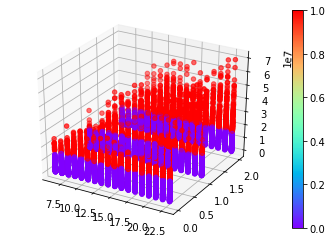

,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y,geometry
1,930b285c764e554f338f671864b30d3941935b00,3821116bcdc789c9d54369ddd58b8e75fafdcb59,9.208433,45.445358,POINT (9.20843 45.44536)
2,930b285c764e554f338f671864b30d3941935b00,9ed9d0f30e21c0218c987496c433e11dd611c9d2,9.208433,45.445358,POINT (9.20843 45.44536)
12,b1184e88a14997cf01299b13908568d949a1be53,cdff26a5c4ce73ee8aef8684045e74727f395bf5,9.227019,45.463230,POINT (9.22702 45.46323)
13,b1184e88a14997cf01299b13908568d949a1be53,01e15165b5683c9f4922e7ffdc82471e479e7779,9.227019,45.463230,POINT (9.22702 45.46323)
14,b1184e88a14997cf01299b13908568d949a1be53,7acc6c5a9eaca072979d30109d52e4375cdc11f7,9.227019,45.463230,POINT (9.22702 45.46323)
...,...,...,...,...,...
950,f161d41795890db558d3e34b6ddd61bda77e8764,dfee8b67dd0f806325484e2fd32e1bdcb93bd491,9.175056,45.460056,POINT (9.17506 45.46006)
951,f161d41795890db558d3e34b6ddd61bda77e8764,963d7b7a00e2b9c7d20fe313dced0388be5b4dac,9.175056,45.460056,POINT (9.17506 45.46006)
955,3fdbc872d547a3c5b6404cb90960ed717085fa0b,8c203d8b0fb924503c6af744f2035aa43867d1fb,9.158972,45.505527,POINT (9.15897 45.50553)
956,3fdbc872d547a3c5b6404cb90960ed717085fa0b,82a9f5269531147ac5ce15ff92fd8172d1ff0bcf,9.158972,45.505527,POINT (9.15897 45.50553)


,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y,geometry
0,930b285c764e554f338f671864b30d3941935b00,b7de6cd46e855aaec8e28b26d1767e7a738819db,9.208433,45.445358,POINT (9.20843 45.44536)
36,6c6e77c44a598b0e34a0ff19832137cc24a31db7,6807ba8768ea1c61b922795a02dd6e8c1f5823e1,9.214511,45.469421,POINT (9.21451 45.46942)
42,20dc89dfa2970fba49975c8021d729dbb93d9c86,5a6ea208eb7b2dcbf59dc457706b8b04a5a8e1b2,9.193417,45.444824,POINT (9.19342 45.44482)
43,20dc89dfa2970fba49975c8021d729dbb93d9c86,b713a4f2dc59f35a0dfa1e598cf4cf01659bd2e8,9.193417,45.444824,POINT (9.19342 45.44482)
44,20dc89dfa2970fba49975c8021d729dbb93d9c86,b7eed02edd74696bf65d055085787772478961de,9.193417,45.444824,POINT (9.19342 45.44482)
...,...,...,...,...,...
803,4098516471522b42b596da741a12b408af23877a,6805bcdd345fe8aceaf193d5cd0efec689627cfd,9.196639,45.471111,POINT (9.19664 45.47111)
804,4098516471522b42b596da741a12b408af23877a,127cd95aaab8bc59186b5db827b82b2ffa4fc635,9.196639,45.471111,POINT (9.19664 45.47111)
810,49ff5de15a6786a0953cecc4680e2b9ef112f812,a0ee7d4b37e2f1244a6878583b126955a688d4e7,9.172030,45.530338,POINT (9.17203 45.53034)
835,48793330deecdce4acbd851bfc0495085448c5a2,594983843bd6836e0611fd67889dddd26863c2f6,9.194750,45.496971,POINT (9.19475 45.49697)


In [22]:
# CLUSTERING PART 

#filtering by weekdays and daily business hours
x = covid_free[covid_free['Date'].dt.hour.between(6, 24)]

hours = pd.to_datetime(x['Date']).dt.hour
weekdays = x['Date'].dt.weekday
x['Hour'] = hours
x['Weekday'] = weekdays


#creating dataset with relevant data from previous DataFrame
x = x[['ECELL_ID', 'DL_VOL', 'Hour', 'Weekday']]
x = x.groupby(['ECELL_ID', 'Hour', 'Weekday']).mean()
x = x.reset_index()
#splitting between week and weekend days
x['Weekday'] = x['Weekday'].apply(lambda x : 0 if x < 5 else (1 if x == 5 else 2))
x = x.groupby(['ECELL_ID', 'Hour', 'Weekday']).mean()
x = x.reset_index()


# selecting the DL_Volume column as entry data for the k-means clustering algorithm
dl_array = x[['DL_VOL', 'Hour', 'Weekday']]
# creating a 2 clusters k-means value clustering class and fitting the DataFrame accordingly
kmeans = KMeans(n_clusters=2, random_state=0).fit(dl_array)
identified_clusters = kmeans.fit_predict(dl_array)
data_with_clusters = x.copy()
data_with_clusters['Clusters'] = identified_clusters


# Scattering the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(data_with_clusters['Hour'], data_with_clusters['Weekday'], data_with_clusters['DL_VOL'], c = data_with_clusters['Clusters'],
            cmap='rainbow')
fig.colorbar(img)
plt.show()

data_with_clusters = data_with_clusters[['ECELL_ID', 'Clusters']]
data_with_clusters = data_with_clusters.groupby(['ECELL_ID']).mean().round()


# Splitting residential cells from non-residential ones
support_business = data_with_clusters.drop(data_with_clusters[data_with_clusters.Clusters < 1].index)
support_residential = round(data_with_clusters.drop(data_with_clusters[data_with_clusters.Clusters > 0].index))
support_residential = support_residential.reset_index()
support_business = support_business.reset_index()


# Splitting all the data according to the clusters
residential_data = data.loc[data['ECELL_ID'].isin(support_residential['ECELL_ID'])]
business_data = data.loc[data['ECELL_ID'].isin(support_business['ECELL_ID'])]

# Splitting all the locations according to the clusters
residential_locations = locations.loc[locations['ECELL_ID'].isin(support_residential['ECELL_ID'])]
business_locations = locations.loc[locations['ECELL_ID'].isin(support_business['ECELL_ID'])]

display(residential_locations)
display(business_locations)


In [23]:
# We can split the CLUSTERED dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_residential = residential_data[residential_data['Date'] < full_lockdown_end_date]
full_lockdown_residential = full_lockdown_residential[full_lockdown_residential['Date'] > full_lockdown_start_date]

full_lockdown_business = business_data[business_data['Date'] < full_lockdown_end_date]
full_lockdown_business = full_lockdown_business[full_lockdown_business['Date'] > full_lockdown_start_date]

restrictions_residential = residential_data[residential_data['Date'] < restrictions_end_date]
restrictions_residential = restrictions_residential[restrictions_residential['Date'] > restrictions_start_date]

restrictions_business = business_data[business_data['Date'] < restrictions_end_date]
restrictions_business = restrictions_business[restrictions_business['Date'] > restrictions_start_date]

covid_free_residential = residential_data[residential_data['Date'] < covid_free_end_date]
covid_free_residential = covid_free_residential[covid_free_residential['Date'] > covid_free_start_date]

covid_free_business = business_data[business_data['Date'] < covid_free_end_date]
covid_free_business = covid_free_business[covid_free_business['Date'] > covid_free_start_date]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


# Data Visualization

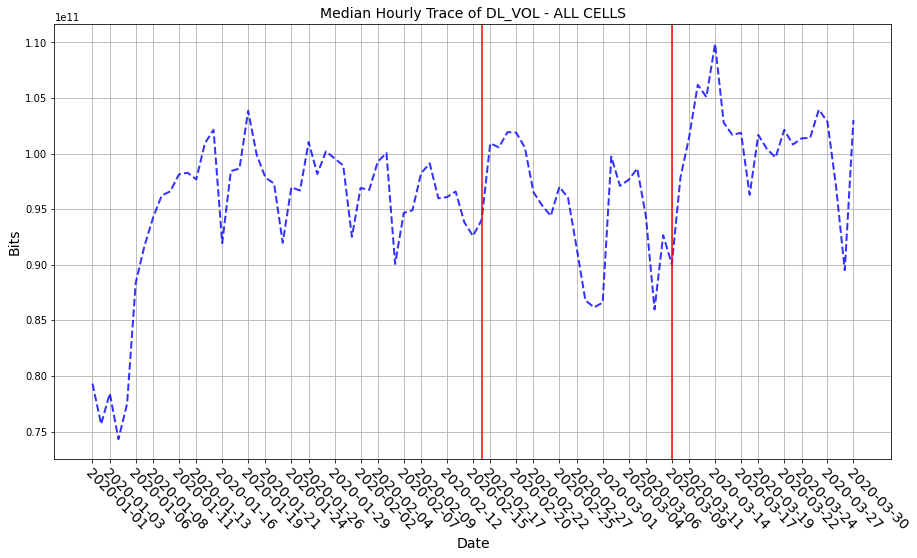

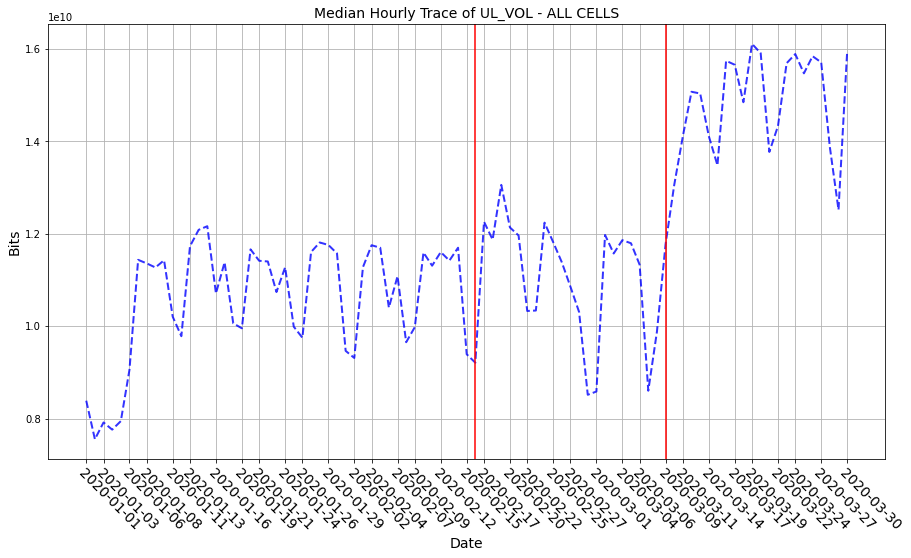

In [24]:
# This section plots the Traffic Downloaded from the ALL cells in a month

def periods_trace_plot_daily(ref_KPI, operation, ylabel):
  # Create a copy of the original dataset
  data_temp = data.copy()

  # Set Daily granularity instead of Hourly granularity
  data_temp['Date'] = pd.to_datetime(data_temp['Date']).dt.date

  # Used to identify days with less measurments
  # pd.set_option('display.max_rows', None)
  # display(data_temp['Date'].value_counts())

  # We drop the data about 31-03-2020 because we are computing daily stats and in this date we have only one measurment for the whole day
  ref = data_temp.set_index('Date').sort_values('Date').drop(datetime.date(year=2020,month=3,day=31)).loc[:, [ref_KPI]]

  # Sum all the "ref_KPI" values with same "Date"
  ref = ref.groupby(level=0).sum()

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  # plot data
  ax.plot(list(range(0,len(ref))), ref[ref_KPI], linestyle='--', lw=2, color='b', alpha=.8) 

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  ticks_label = ref.index
  ticks = np.linspace(0, len(ref)-1, 35, dtype=int)
  plt.xticks(ticks = ticks, labels = ticks_label[ticks], fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
  plt.xlabel('Date', color='black', fontsize=14)
  plt.ylabel(ylabel, color='black', fontsize=14) # unit of measure depends on the considered KPI
  plt.title('Median Hourly Trace of '+ref_KPI+' - ALL CELLS', fontsize=14)

  # Draw a red line when there is a period change
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=2,day=16)) ,color = 'r',label = 'Restrictions')
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=3,day=9)) ,color = 'r',label = 'Full Lockdown')

  plt.show()

periods_trace_plot_daily('DL_VOL', 0, 'Bits')
print()
periods_trace_plot_daily('UL_VOL', 0, 'Bits')
print()

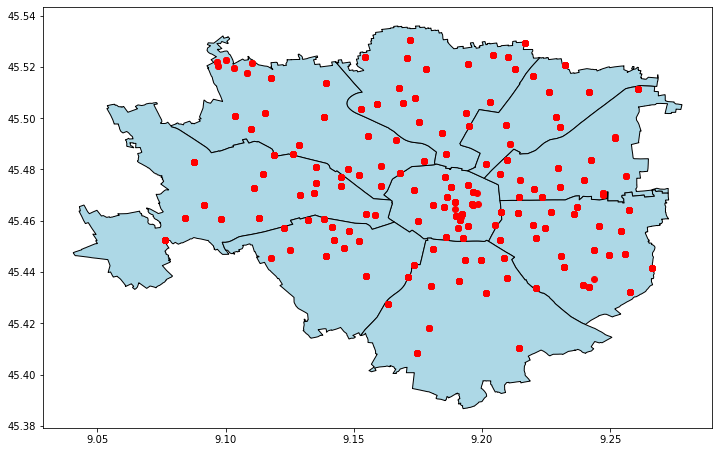

In [25]:
# Cell rappresentation with Geopandas
geo_data = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG_X, locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data.plot(ax=ax, color='red')
plt.show()


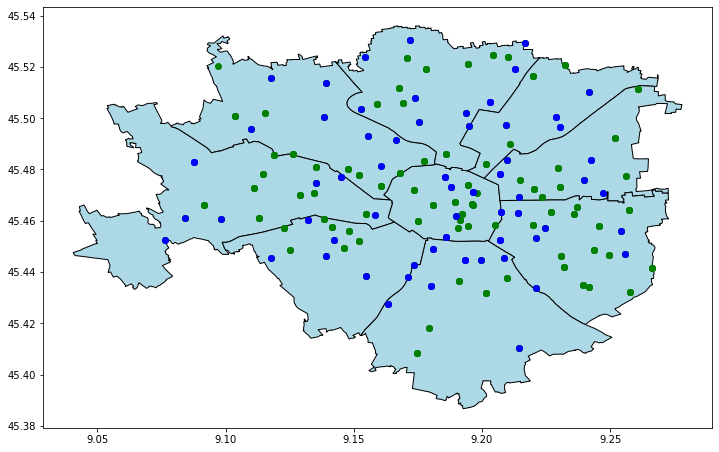

In [26]:
# Cell differentiation with Geopandas
geo_data_residential = geopandas.GeoDataFrame(residential_locations, geometry=geopandas.points_from_xy(residential_locations.LONG_X, residential_locations.LAT_Y))
geo_data_business = geopandas.GeoDataFrame(business_locations, geometry=geopandas.points_from_xy(business_locations.LONG_X, business_locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data_residential.plot(ax=ax, color='green')
geo_data_business.plot(ax=ax, color='blue')
plt.show()

In [27]:
# This section makes a box plot of the daily statiscs regarding the number of connected 
# users to the cell taken as example. For each day, the following statistics are extracted from the considered
# KPI:
# - Median Value
# - 25th and 75th Quantiles
# - Max and Min values

# For reference about how to read a box plot go here: 
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51


def data_dataset_daily(dataset, ref_KPI):
  # Set Daily granularity instead of Hourly granularity
  dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
  # Set new dataset index to "Date" and keep only the "ref_KPI" column
  return dataset.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]


# If operation == 0 do the sum of the ref_KPI of the day
# If operation == 1 do the average of the ref_KPI of the day
def dataset_operation(dataset, operation):
  if operation == 0:
    dataset = dataset.groupby(level=0).sum()
  else:
    dataset = dataset.groupby(level=0).mean()
  return dataset


def statistical_comparison(periods_lables, median_values, average_values, sd_values, id_1, id_2, ref_KPI):
  print('>>>------', periods_lables[id_1], ref_KPI, 'Variation ------<<<')
  print("Median: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((median_values[id_2] - median_values[id_1]) / abs(median_values[id_1])) * 100))
  print("Average: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((average_values[id_2] - average_values[id_1]) / abs(average_values[id_1])) * 100))
  print("Std. deviation: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((sd_values[id_2] - sd_values[id_1]) / abs(sd_values[id_1])) * 100))


def periods_box_plot_daily(periods, periods_lables, ref_KPI, operation, ylabel):

  periods_copy = []
  periods_data_list = []
  N_periods = len(periods)

  for i in range(N_periods):
    periods_copy.append(periods[i].copy())
    periods_copy[i] = data_dataset_daily(periods_copy[i], ref_KPI)
    periods_copy[i] = periods_copy[i].loc[:, [ref_KPI]].drop(datetime.date(year=2020,month=3,day=31), errors='ignore')
    periods_copy[i] = dataset_operation(periods_copy[i], ref_KPI)
    # periods_copy have only one KPI but we need "[ref_KPI]" to use the "tolist()" function
    periods_data_list.append(periods_copy[i][ref_KPI].tolist())

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  bplots = []
  for i in range(N_periods):
    bplots.append(ax.boxplot(periods_data_list[i], positions = [i], patch_artist=True))

  for bplot in bplots:
    for patch in bplot['boxes']:
      patch.set_facecolor('lightblue')

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  plt.xticks(ticks = list(range(N_periods)), labels = periods_lables, fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), ha="center") 
  plt.ylabel(ylabel, color='black', fontsize=14)
  if N_periods > 3:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

  plt.title('Box Plot of Median '+ref_KPI+' - ALL CELLs', fontsize=14)
  plt.show()

  print()
  
  median_values = []
  average_values = []
  sd_values = []

  # Print statistical informations:
  for i in range(N_periods):
    print('---------', periods_lables[i], ref_KPI,'---------')
    median_values.append(np.median(periods_data_list[i]))
    print('Median value:', "{0:.2f}".format(median_values[i]))
    average_values.append(np.mean(periods_data_list[i]))
    print('Average value:', "{0:.2f}".format( average_values[i]))
    sd_values.append(np.std(periods_data_list[i]))
    print('Standard deviation:', "{0:.2f}".format(sd_values[i]))

  if N_periods > 3:
    # Statistical comparison between residential and business in the same period
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 4, 5, ref_KPI)

    # Statistical comparison between residential periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 4, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 4, ref_KPI)

    # Statistical comparison between business periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 5, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 3, 5, ref_KPI)
  else:
    # Statistical comparison between periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 2, ref_KPI)


In [28]:
def plot_stats(periods, periods_lables):
  periods_box_plot_daily(periods, periods_lables, 'DL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'ERAB_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'CS_SR', 1, 'Calls')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_RE_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'IntraF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'InterF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'Hin_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_DL_Used_Avg', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_UL_Used_Avg', 1, 'Bits')
  print()

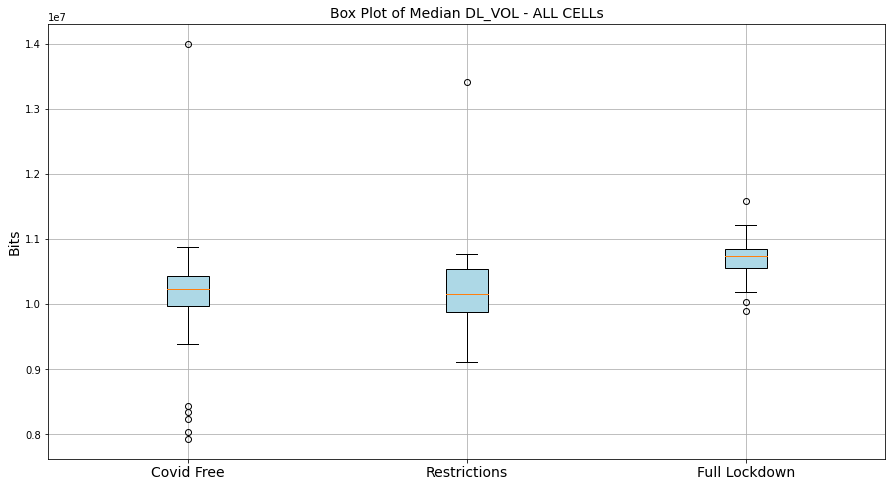


--------- Covid Free DL_VOL ---------
Median value: 10228299.84
Average value: 10098197.62
Standard deviation: 897092.93
--------- Restrictions DL_VOL ---------
Median value: 10155150.32
Average value: 10218866.57
Standard deviation: 820310.10
--------- Full Lockdown DL_VOL ---------
Median value: 10736376.01
Average value: 10692283.22
Standard deviation: 380883.26
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.72%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.19%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -8.56%
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.97%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.88%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -57.54%
>>>------ Restrictions DL_VOL Variation ------<<<
Median: difference between [ Restriction

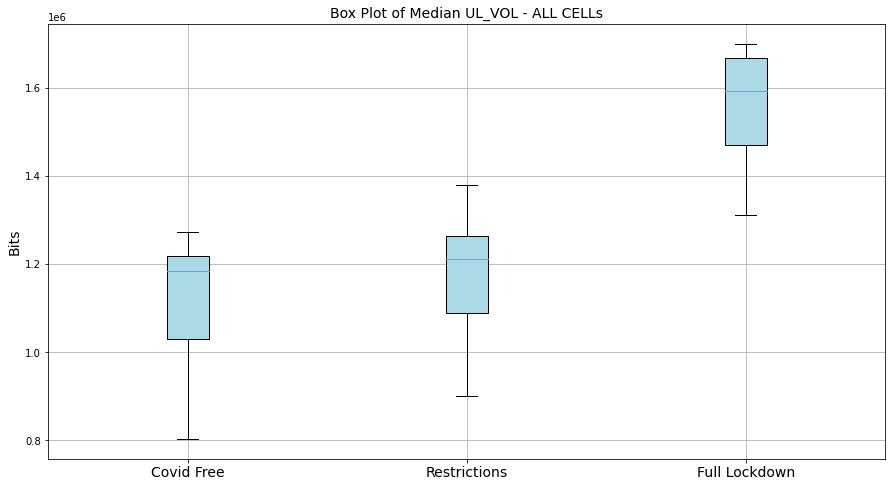


--------- Covid Free UL_VOL ---------
Median value: 1185227.90
Average value: 1119706.01
Standard deviation: 130533.09
--------- Restrictions UL_VOL ---------
Median value: 1211847.29
Average value: 1168873.07
Standard deviation: 132182.07
--------- Full Lockdown UL_VOL ---------
Median value: 1592944.30
Average value: 1562048.34
Standard deviation: 117307.45
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 2.25%
Average: difference between [ Covid Free ] and [ Restrictions ]: 4.39%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 1.26%
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 34.40%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.51%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -10.13%
>>>------ Restrictions UL_VOL Variation ------<<<
Median: difference between [ Restrictions ] an

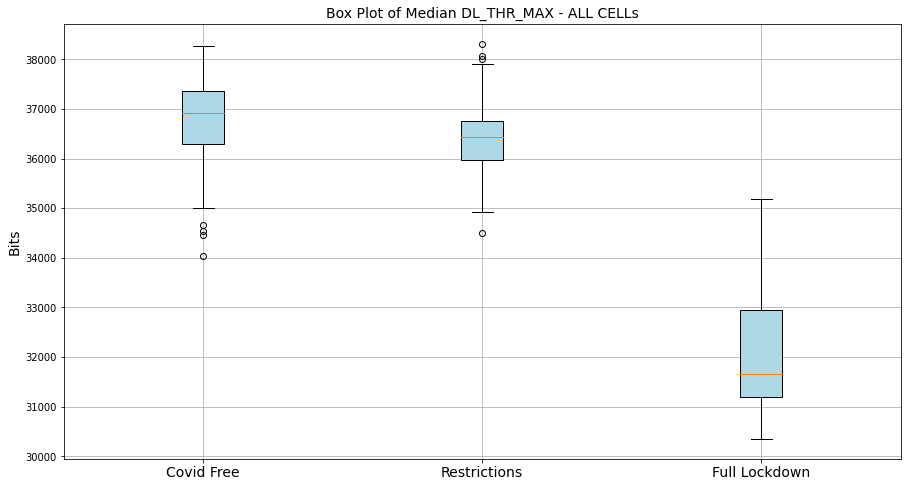


--------- Covid Free DL_THR_MAX ---------
Median value: 36921.34
Average value: 36688.49
Standard deviation: 962.73
--------- Restrictions DL_THR_MAX ---------
Median value: 36431.24
Average value: 36451.33
Standard deviation: 952.23
--------- Full Lockdown DL_THR_MAX ---------
Median value: 31657.86
Average value: 32185.83
Standard deviation: 1308.02
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.33%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.65%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -1.09%
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -14.26%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -12.27%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 35.87%
>>>------ Restrictions DL_THR_MAX Variation ------<<<
Median: difference between [ Restricti

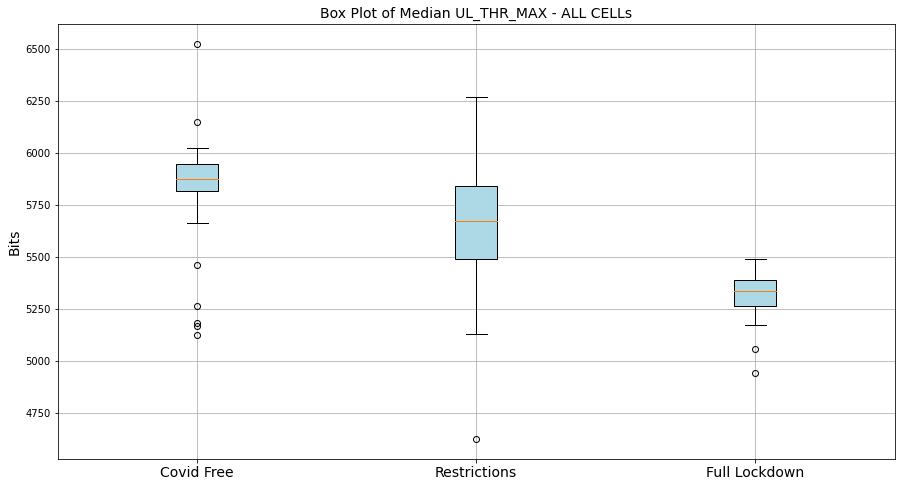


--------- Covid Free UL_THR_MAX ---------
Median value: 5875.97
Average value: 5832.88
Standard deviation: 242.88
--------- Restrictions UL_THR_MAX ---------
Median value: 5674.36
Average value: 5662.31
Standard deviation: 378.19
--------- Full Lockdown UL_THR_MAX ---------
Median value: 5333.43
Average value: 5303.49
Standard deviation: 128.26
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -3.43%
Average: difference between [ Covid Free ] and [ Restrictions ]: -2.92%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 55.71%
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -9.08%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -47.19%
>>>------ Restrictions UL_THR_MAX Variation ------<<<
Median: difference between [ Restrictions ] an

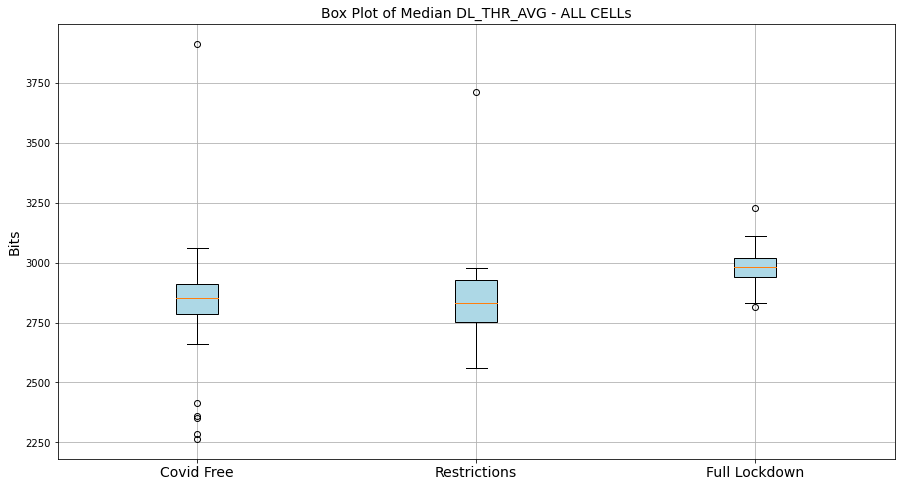


--------- Covid Free DL_THR_AVG ---------
Median value: 2851.08
Average value: 2822.99
Standard deviation: 239.82
--------- Restrictions DL_THR_AVG ---------
Median value: 2829.85
Average value: 2846.64
Standard deviation: 218.02
--------- Full Lockdown DL_THR_AVG ---------
Median value: 2979.95
Average value: 2982.10
Standard deviation: 90.86
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.74%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -9.09%
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.52%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.64%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -62.11%
>>>------ Restrictions DL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ 

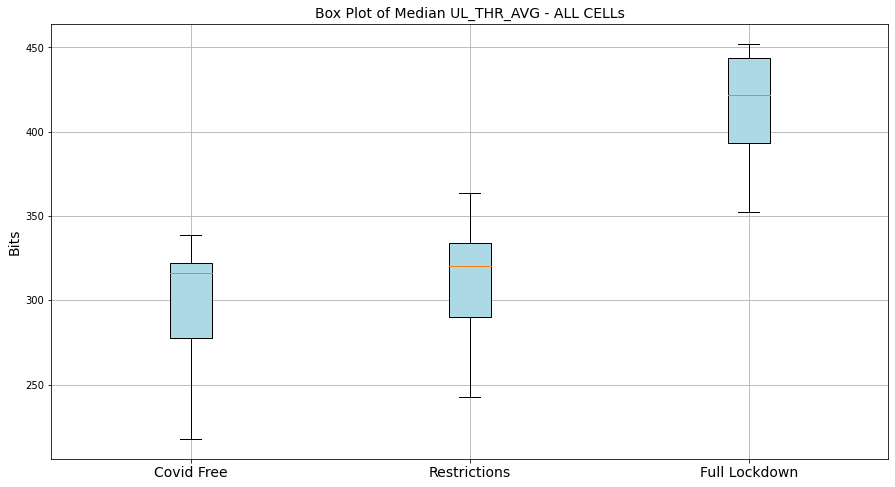


--------- Covid Free UL_THR_AVG ---------
Median value: 316.21
Average value: 298.66
Standard deviation: 32.52
--------- Restrictions UL_THR_AVG ---------
Median value: 320.31
Average value: 310.13
Standard deviation: 33.48
--------- Full Lockdown UL_THR_AVG ---------
Median value: 421.88
Average value: 416.74
Standard deviation: 29.52
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 1.30%
Average: difference between [ Covid Free ] and [ Restrictions ]: 3.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.96%
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 33.41%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.54%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
>>>------ Restrictions UL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lock

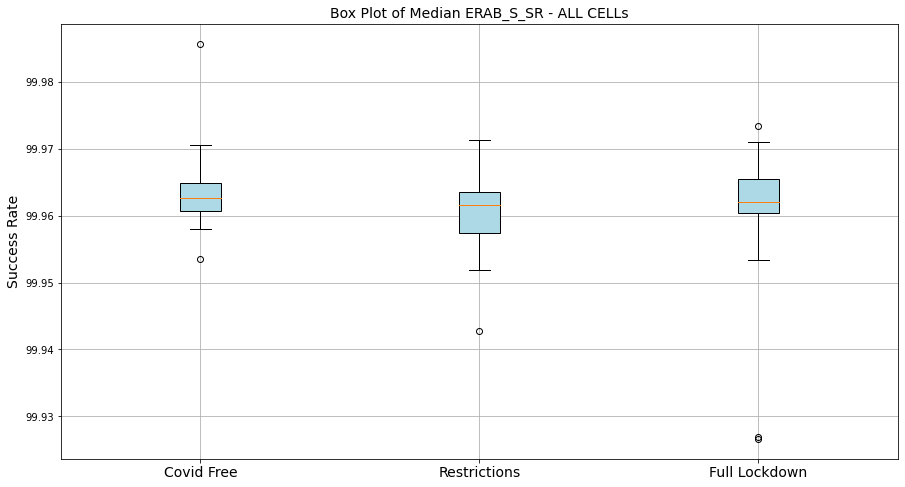


--------- Covid Free ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.00
--------- Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 29.56%
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 136.08%
>>>------ Restrictions ERAB_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 0.0

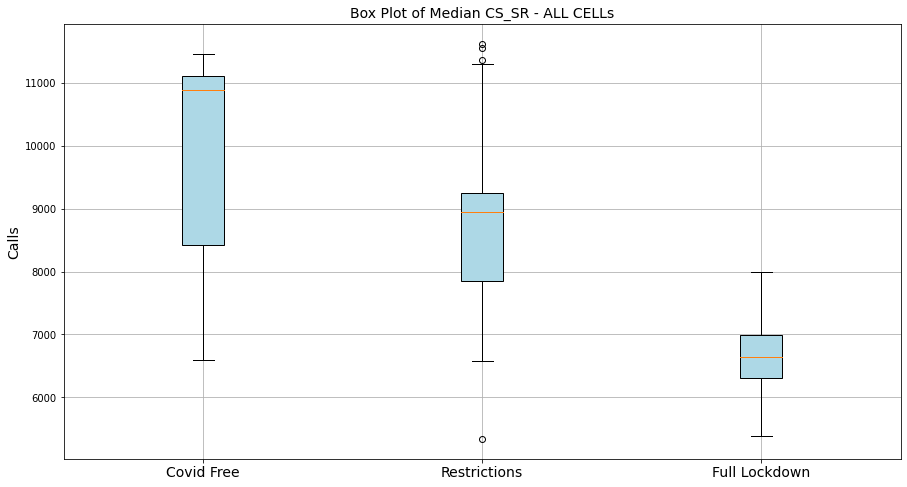


--------- Covid Free CS_SR ---------
Median value: 10881.89
Average value: 9870.74
Standard deviation: 1529.75
--------- Restrictions CS_SR ---------
Median value: 8950.49
Average value: 8801.19
Standard deviation: 1643.62
--------- Full Lockdown CS_SR ---------
Median value: 6640.26
Average value: 6731.95
Standard deviation: 633.76
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -17.75%
Average: difference between [ Covid Free ] and [ Restrictions ]: -10.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 7.44%
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -38.98%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -31.80%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -58.57%
>>>------ Restrictions CS_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -25

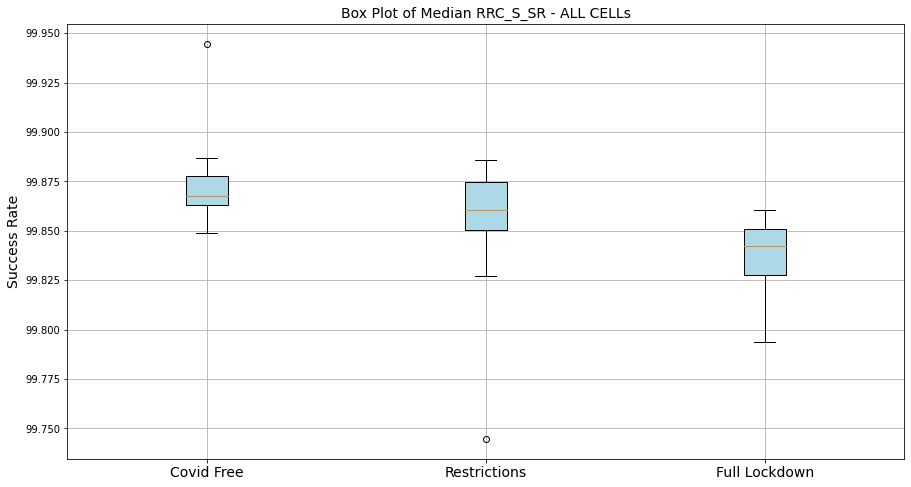


--------- Covid Free RRC_S_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.01
--------- Restrictions RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.03
--------- Full Lockdown RRC_S_SR ---------
Median value: 99.84
Average value: 99.84
Standard deviation: 0.02
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 99.34%
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 31.34%
>>>------ Restrictions RRC_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.02%
Ave

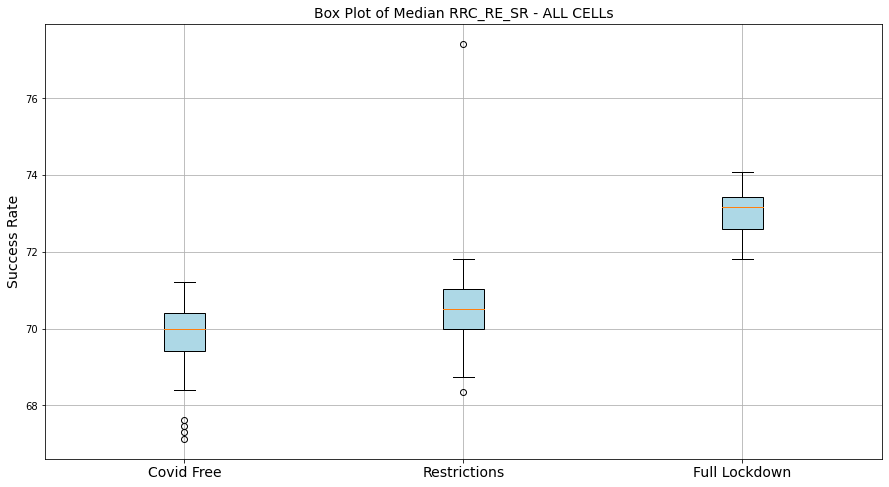


--------- Covid Free RRC_RE_SR ---------
Median value: 69.99
Average value: 69.77
Standard deviation: 0.95
--------- Restrictions RRC_RE_SR ---------
Median value: 70.50
Average value: 70.67
Standard deviation: 1.63
--------- Full Lockdown RRC_RE_SR ---------
Median value: 73.17
Average value: 73.05
Standard deviation: 0.60
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.73%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.28%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 71.04%
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.54%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 4.70%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -37.29%
>>>------ Restrictions RRC_RE_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 3.79%
A

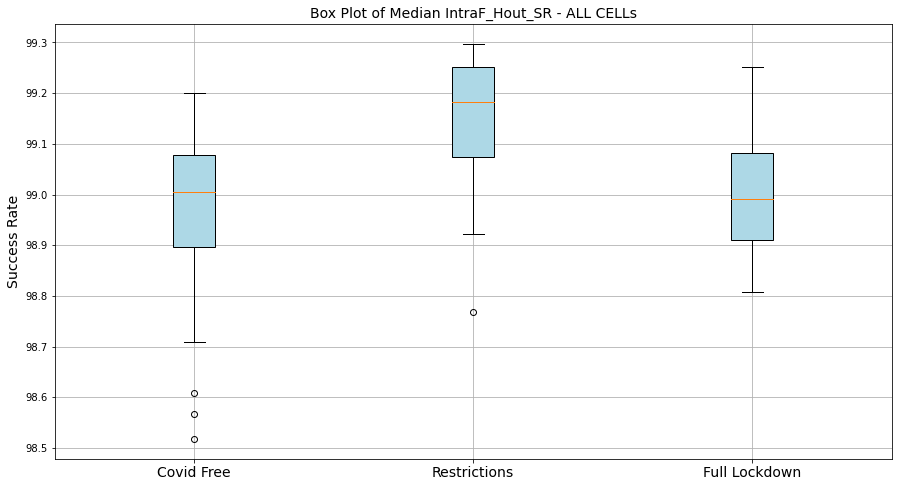


--------- Covid Free IntraF_Hout_SR ---------
Median value: 99.01
Average value: 98.97
Standard deviation: 0.16
--------- Restrictions IntraF_Hout_SR ---------
Median value: 99.18
Average value: 99.15
Standard deviation: 0.13
--------- Full Lockdown IntraF_Hout_SR ---------
Median value: 98.99
Average value: 99.00
Standard deviation: 0.12
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -20.25%
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.02%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -28.06%
>>>------ Restrictions IntraF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions 

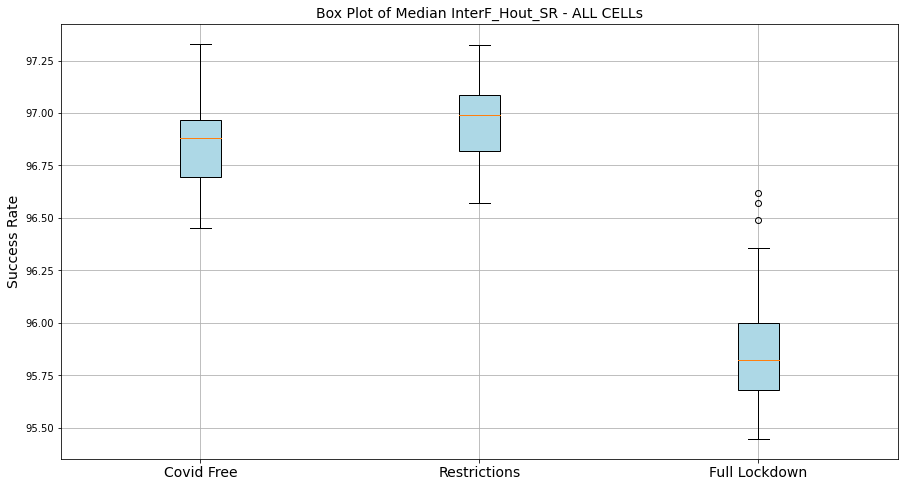


--------- Covid Free InterF_Hout_SR ---------
Median value: 96.88
Average value: 96.85
Standard deviation: 0.21
--------- Restrictions InterF_Hout_SR ---------
Median value: 96.99
Average value: 96.97
Standard deviation: 0.20
--------- Full Lockdown InterF_Hout_SR ---------
Median value: 95.82
Average value: 95.91
Standard deviation: 0.32
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.11%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.12%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -4.99%
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -1.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.97%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 52.92%
>>>------ Restrictions InterF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions ]

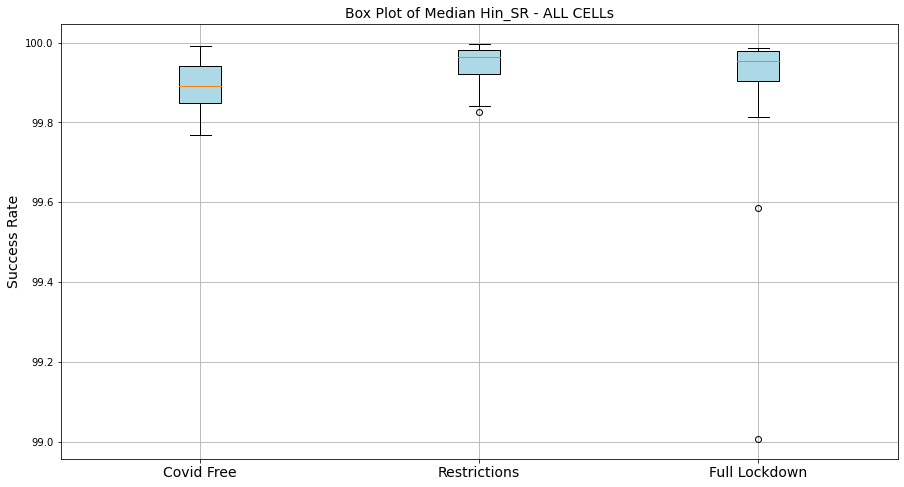


--------- Covid Free Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Restrictions Hin_SR ---------
Median value: 99.96
Average value: 99.94
Standard deviation: 0.05
--------- Full Lockdown Hin_SR ---------
Median value: 99.95
Average value: 99.88
Standard deviation: 0.21
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.07%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.05%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -13.86%
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 0.06%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 258.46%
>>>------ Restrictions Hin_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.01%
Average: differe

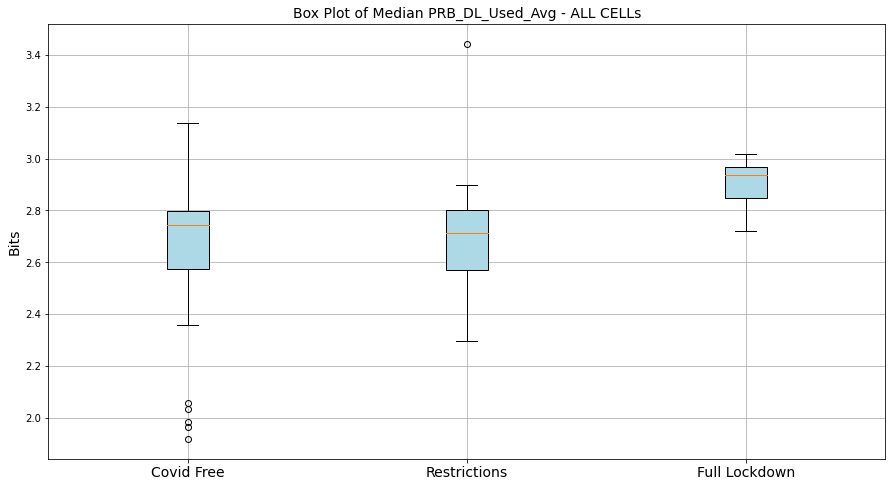


--------- Covid Free PRB_DL_Used_Avg ---------
Median value: 2.74
Average value: 2.64
Standard deviation: 0.26
--------- Restrictions PRB_DL_Used_Avg ---------
Median value: 2.71
Average value: 2.69
Standard deviation: 0.23
--------- Full Lockdown PRB_DL_Used_Avg ---------
Median value: 2.94
Average value: 2.90
Standard deviation: 0.09
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.02%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -11.47%
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 7.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 9.77%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -65.73%
>>>------ Restrictions PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

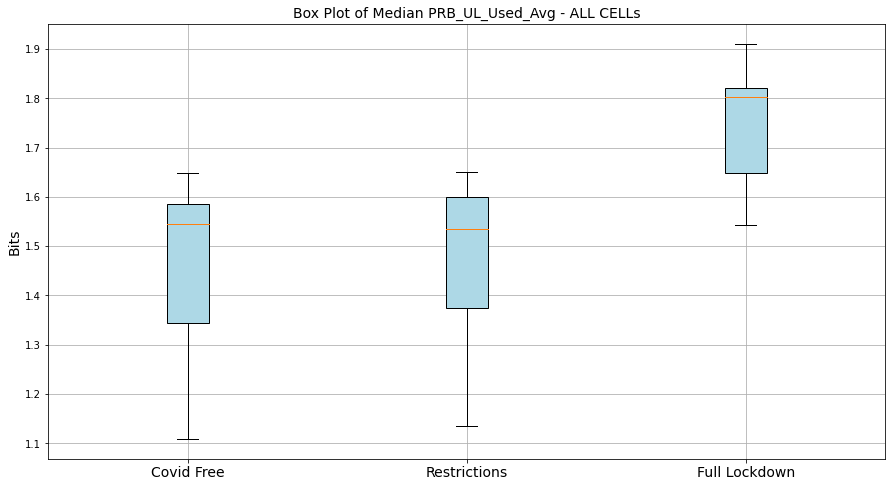


--------- Covid Free PRB_UL_Used_Avg ---------
Median value: 1.55
Average value: 1.46
Standard deviation: 0.16
--------- Restrictions PRB_UL_Used_Avg ---------
Median value: 1.53
Average value: 1.47
Standard deviation: 0.16
--------- Full Lockdown PRB_UL_Used_Avg ---------
Median value: 1.80
Average value: 1.75
Standard deviation: 0.11
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.71%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.81%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.24%
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 16.70%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 19.93%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -31.54%
>>>------ Restrictions PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

In [29]:
periods = [covid_free, restrictions, full_lockdown]
plot_stats(periods, periods_lables)

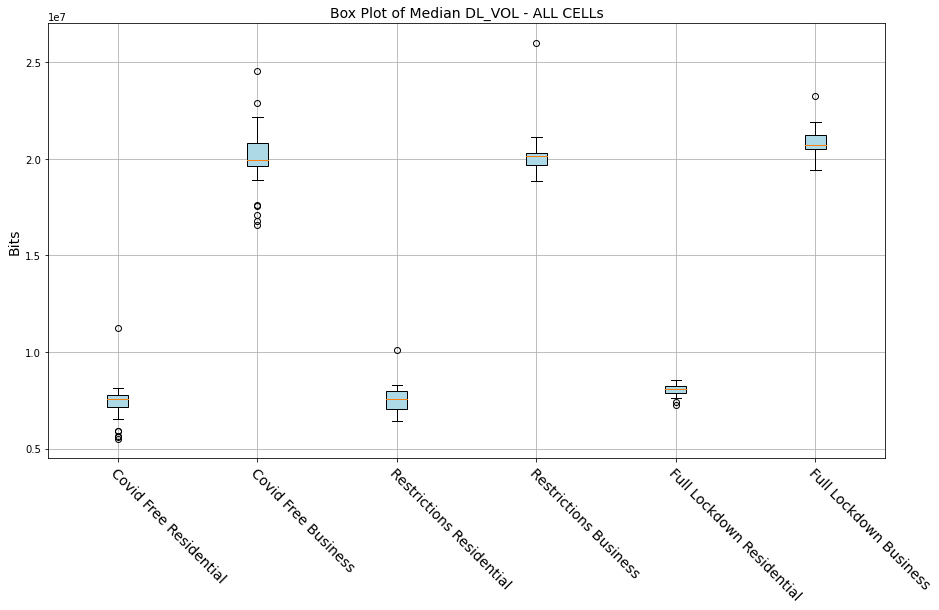


--------- Covid Free Residential DL_VOL ---------
Median value: 7548219.96
Average value: 7418748.99
Standard deviation: 860664.84
--------- Covid Free Business DL_VOL ---------
Median value: 19921103.19
Average value: 20112917.14
Standard deviation: 1499469.16
--------- Restrictions Residential DL_VOL ---------
Median value: 7550654.58
Average value: 7592687.14
Standard deviation: 760843.12
--------- Restrictions Business DL_VOL ---------
Median value: 20155459.69
Average value: 20259295.84
Standard deviation: 1297200.54
--------- Full Lockdown Residential DL_VOL ---------
Median value: 8088919.75
Average value: 8022467.52
Standard deviation: 325160.32
--------- Full Lockdown Business DL_VOL ---------
Median value: 20724736.91
Average value: 20882298.91
Standard deviation: 850314.87
>>>------ Covid Free Residential DL_VOL Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 163.92%
Average: difference between [ Covid Free Residential 

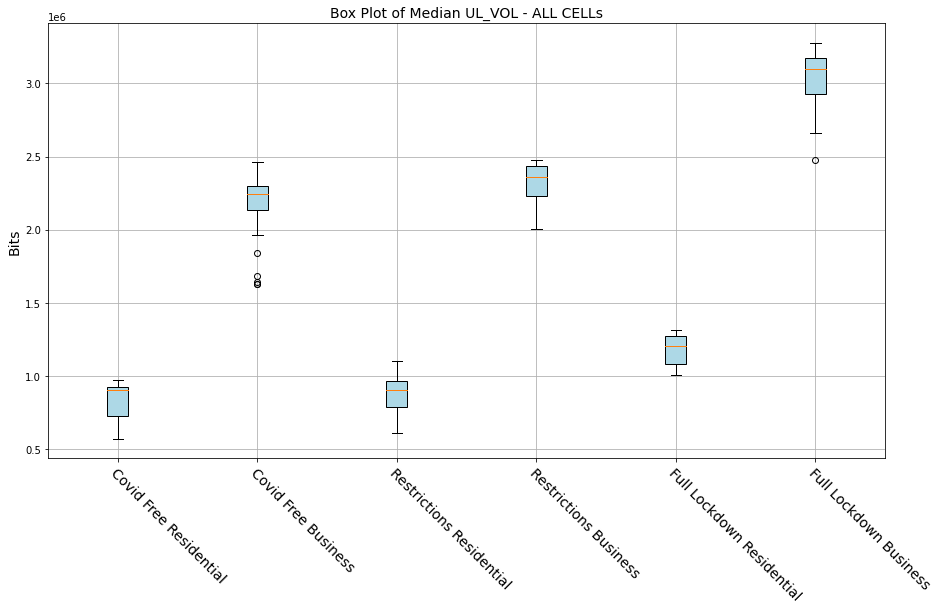


--------- Covid Free Residential UL_VOL ---------
Median value: 904058.50
Average value: 834293.45
Standard deviation: 120640.33
--------- Covid Free Business UL_VOL ---------
Median value: 2241181.42
Average value: 2186994.00
Standard deviation: 198382.12
--------- Restrictions Residential UL_VOL ---------
Median value: 906925.80
Average value: 870030.00
Standard deviation: 130497.84
--------- Restrictions Business UL_VOL ---------
Median value: 2360272.77
Average value: 2311434.79
Standard deviation: 147263.33
--------- Full Lockdown Residential UL_VOL ---------
Median value: 1204612.91
Average value: 1179406.03
Standard deviation: 101311.34
--------- Full Lockdown Business UL_VOL ---------
Median value: 3095434.82
Average value: 3022289.27
Standard deviation: 195551.91
>>>------ Covid Free Residential UL_VOL Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 147.90%
Average: difference between [ Covid Free Residential ] and [ Covi

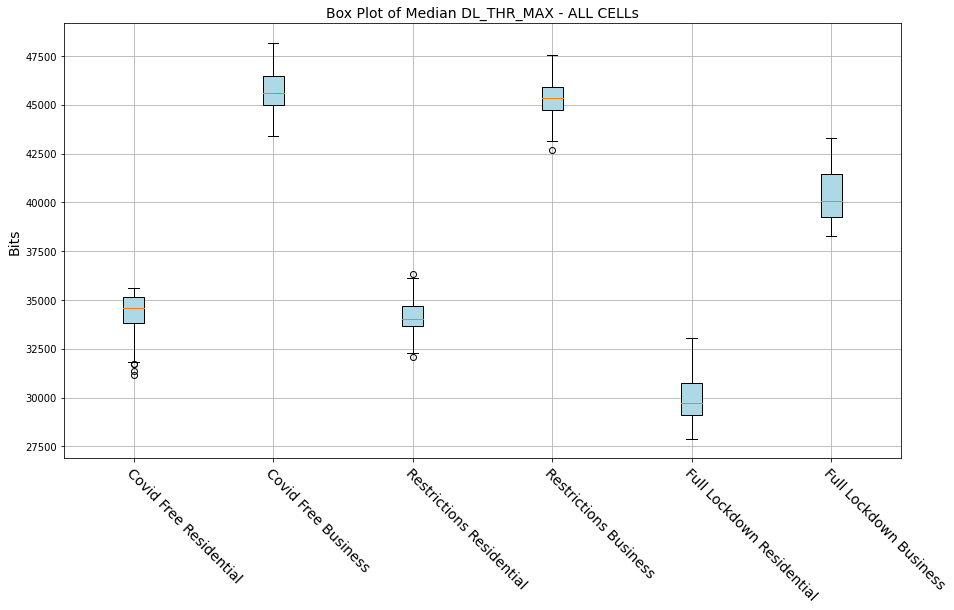


--------- Covid Free Residential DL_THR_MAX ---------
Median value: 34587.48
Average value: 34260.59
Standard deviation: 1183.65
--------- Covid Free Business DL_THR_MAX ---------
Median value: 45620.15
Average value: 45745.33
Standard deviation: 1044.04
--------- Restrictions Residential DL_THR_MAX ---------
Median value: 34042.22
Average value: 34153.37
Standard deviation: 1079.39
--------- Restrictions Business DL_THR_MAX ---------
Median value: 45344.87
Average value: 45238.13
Standard deviation: 1111.00
--------- Full Lockdown Residential DL_THR_MAX ---------
Median value: 29727.81
Average value: 30051.20
Standard deviation: 1338.29
--------- Full Lockdown Business DL_THR_MAX ---------
Median value: 40060.10
Average value: 40333.34
Standard deviation: 1398.01
>>>------ Covid Free Residential DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 31.90%
Average: difference between [ Covid Free Residential ] and [ Covid Fre

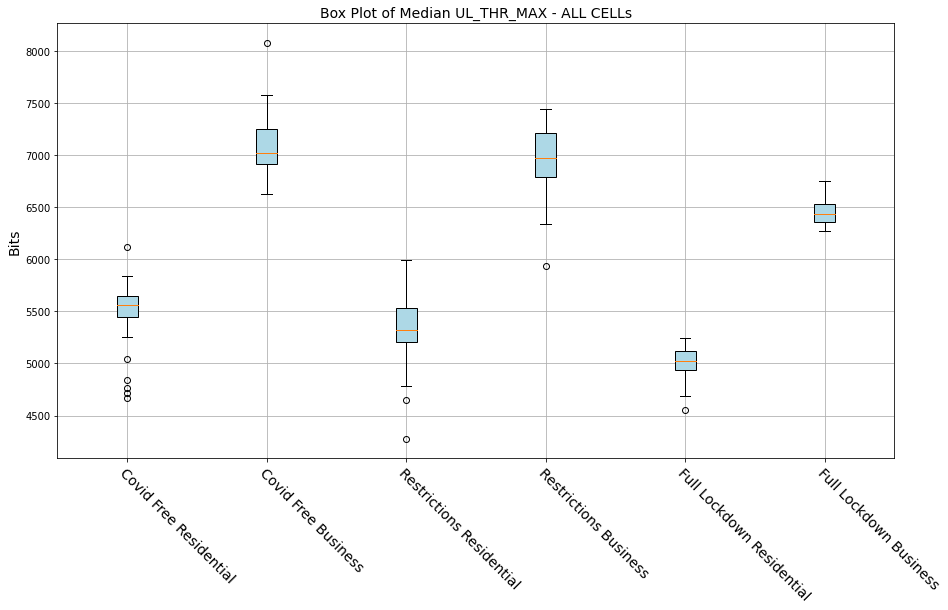


--------- Covid Free Residential UL_THR_MAX ---------
Median value: 5559.38
Average value: 5499.30
Standard deviation: 280.95
--------- Covid Free Business UL_THR_MAX ---------
Median value: 7017.73
Average value: 7077.51
Standard deviation: 257.53
--------- Restrictions Residential UL_THR_MAX ---------
Median value: 5319.29
Average value: 5328.01
Standard deviation: 411.82
--------- Restrictions Business UL_THR_MAX ---------
Median value: 6967.55
Average value: 6940.42
Standard deviation: 338.03
--------- Full Lockdown Residential UL_THR_MAX ---------
Median value: 5025.98
Average value: 5002.39
Standard deviation: 165.60
--------- Full Lockdown Business UL_THR_MAX ---------
Median value: 6435.06
Average value: 6452.68
Standard deviation: 138.09
>>>------ Covid Free Residential UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 26.23%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 28.7

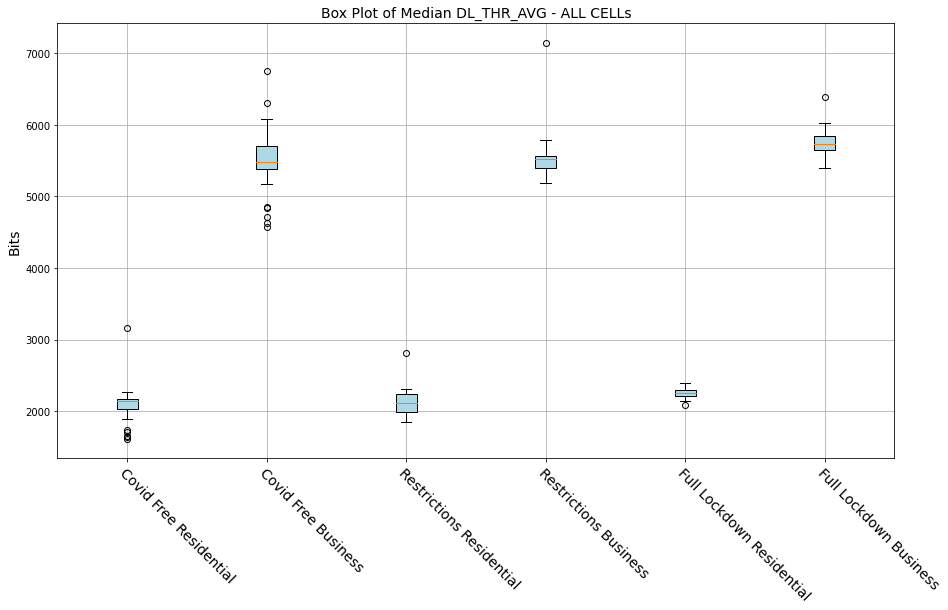


--------- Covid Free Residential DL_THR_AVG ---------
Median value: 2139.94
Average value: 2100.62
Standard deviation: 226.18
--------- Covid Free Business DL_THR_AVG ---------
Median value: 5476.44
Average value: 5522.91
Standard deviation: 407.65
--------- Restrictions Residential DL_THR_AVG ---------
Median value: 2122.21
Average value: 2135.73
Standard deviation: 198.35
--------- Restrictions Business DL_THR_AVG ---------
Median value: 5519.36
Average value: 5564.61
Standard deviation: 354.24
--------- Full Lockdown Residential DL_THR_AVG ---------
Median value: 2259.86
Average value: 2254.42
Standard deviation: 74.49
--------- Full Lockdown Business DL_THR_AVG ---------
Median value: 5725.81
Average value: 5759.47
Standard deviation: 221.29
>>>------ Covid Free Residential DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 155.92%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 162.

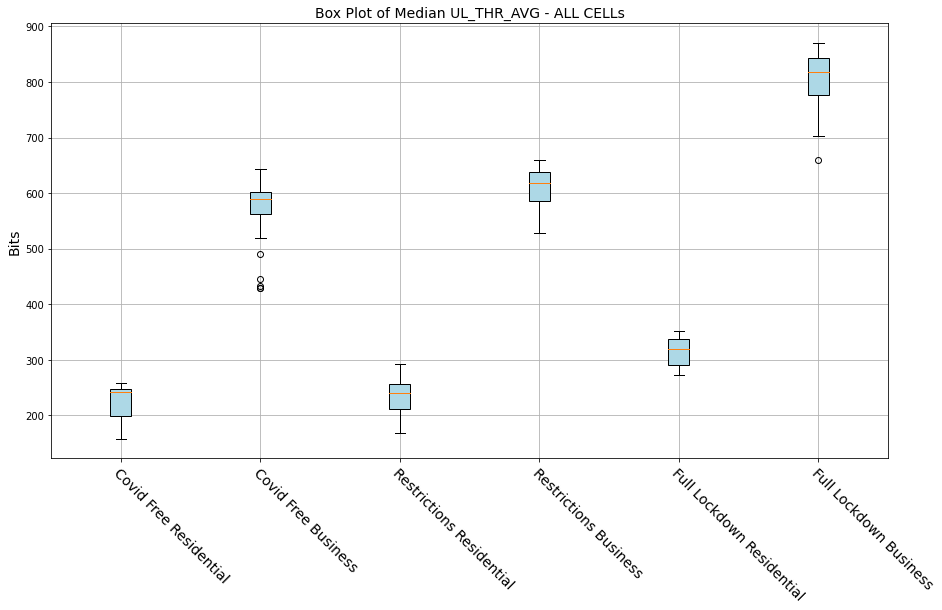


--------- Covid Free Residential UL_THR_AVG ---------
Median value: 242.39
Average value: 224.95
Standard deviation: 29.73
--------- Covid Free Business UL_THR_AVG ---------
Median value: 588.84
Average value: 574.32
Standard deviation: 51.10
--------- Restrictions Residential UL_THR_AVG ---------
Median value: 240.70
Average value: 232.40
Standard deviation: 32.88
--------- Restrictions Business UL_THR_AVG ---------
Median value: 618.69
Average value: 607.32
Standard deviation: 38.36
--------- Full Lockdown Residential UL_THR_AVG ---------
Median value: 319.52
Average value: 315.60
Standard deviation: 25.24
--------- Full Lockdown Business UL_THR_AVG ---------
Median value: 818.45
Average value: 802.72
Standard deviation: 50.80
>>>------ Covid Free Residential UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 142.93%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 155.32%
Std. deviatio

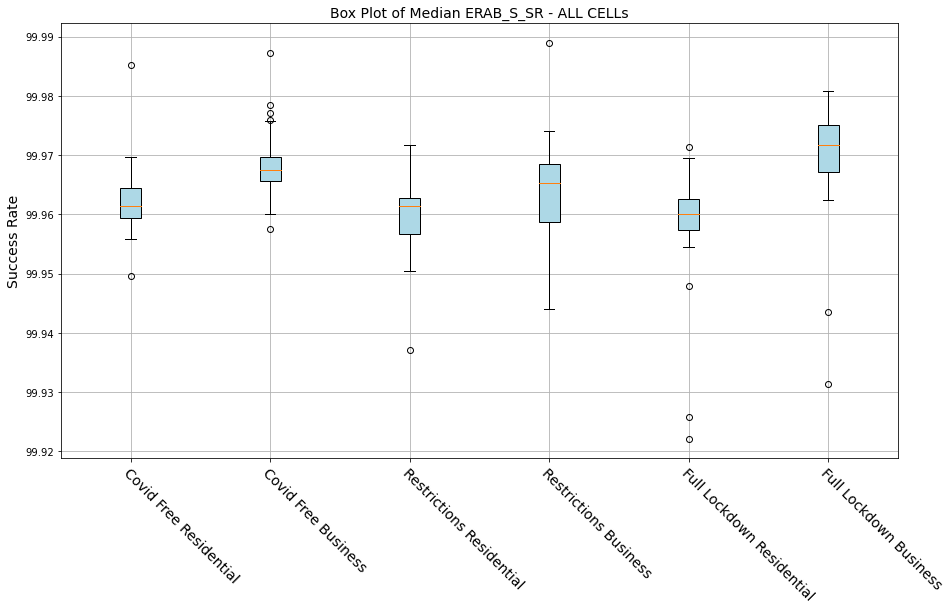


--------- Covid Free Residential ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Covid Free Business ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.00
--------- Restrictions Residential ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Restrictions Business ERAB_S_SR ---------
Median value: 99.97
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown Residential ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown Business ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
>>>------ Covid Free Residential ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.01%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.01%
Std. deviation: difference between [ Covid

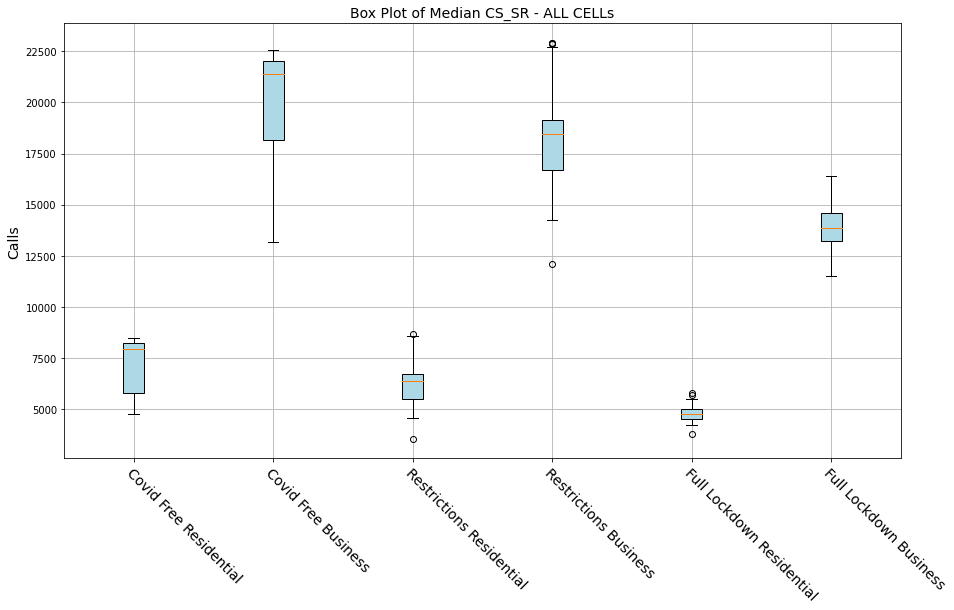


--------- Covid Free Residential CS_SR ---------
Median value: 7970.61
Average value: 7143.12
Standard deviation: 1292.12
--------- Covid Free Business CS_SR ---------
Median value: 21388.03
Average value: 20067.36
Standard deviation: 2570.35
--------- Restrictions Residential CS_SR ---------
Median value: 6405.15
Average value: 6329.09
Standard deviation: 1344.17
--------- Restrictions Business CS_SR ---------
Median value: 18441.64
Average value: 18252.43
Standard deviation: 2813.01
--------- Full Lockdown Residential CS_SR ---------
Median value: 4757.96
Average value: 4820.35
Standard deviation: 487.23
--------- Full Lockdown Business CS_SR ---------
Median value: 13870.29
Average value: 14028.85
Standard deviation: 1216.53
>>>------ Covid Free Residential CS_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 168.34%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 180.93%
Std. deviation: dif

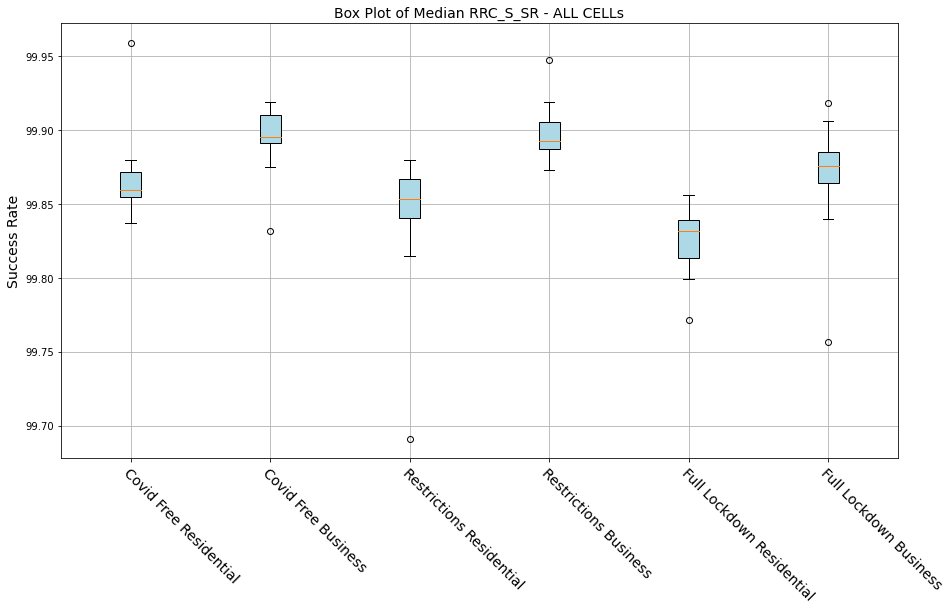


--------- Covid Free Residential RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.02
--------- Covid Free Business RRC_S_SR ---------
Median value: 99.90
Average value: 99.90
Standard deviation: 0.01
--------- Restrictions Residential RRC_S_SR ---------
Median value: 99.85
Average value: 99.85
Standard deviation: 0.04
--------- Restrictions Business RRC_S_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.02
--------- Full Lockdown Residential RRC_S_SR ---------
Median value: 99.83
Average value: 99.83
Standard deviation: 0.02
--------- Full Lockdown Business RRC_S_SR ---------
Median value: 99.88
Average value: 99.87
Standard deviation: 0.03
>>>------ Covid Free Residential RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.04%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.03%
Std. deviation: difference between [ Covid Free R

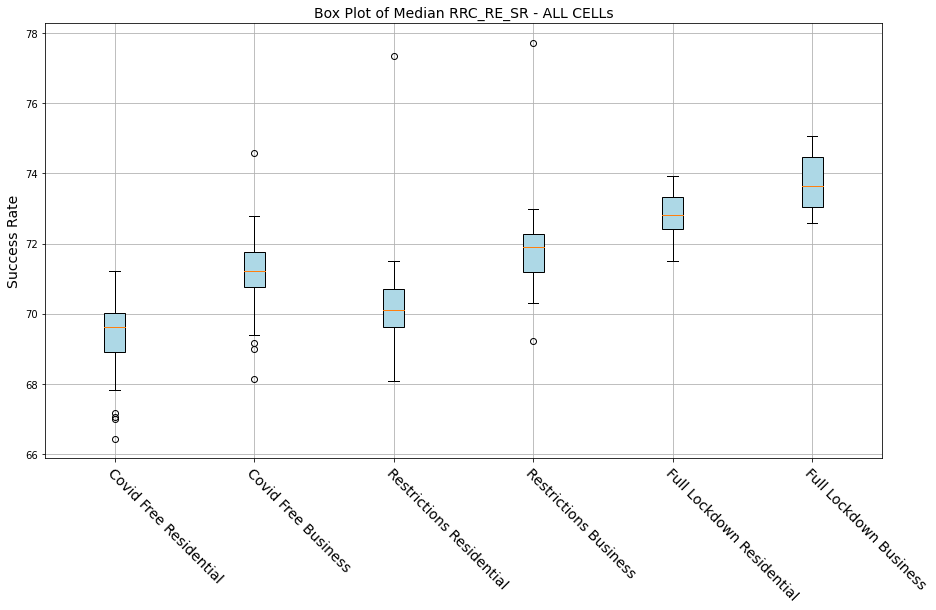


--------- Covid Free Residential RRC_RE_SR ---------
Median value: 69.61
Average value: 69.36
Standard deviation: 1.03
--------- Covid Free Business RRC_RE_SR ---------
Median value: 71.22
Average value: 71.23
Standard deviation: 1.06
--------- Restrictions Residential RRC_RE_SR ---------
Median value: 70.10
Average value: 70.33
Standard deviation: 1.69
--------- Restrictions Business RRC_RE_SR ---------
Median value: 71.90
Average value: 71.88
Standard deviation: 1.49
--------- Full Lockdown Residential RRC_RE_SR ---------
Median value: 72.81
Average value: 72.86
Standard deviation: 0.61
--------- Full Lockdown Business RRC_RE_SR ---------
Median value: 73.64
Average value: 73.75
Standard deviation: 0.76
>>>------ Covid Free Residential RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 2.32%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 2.70%
Std. deviation: difference between [ Covid

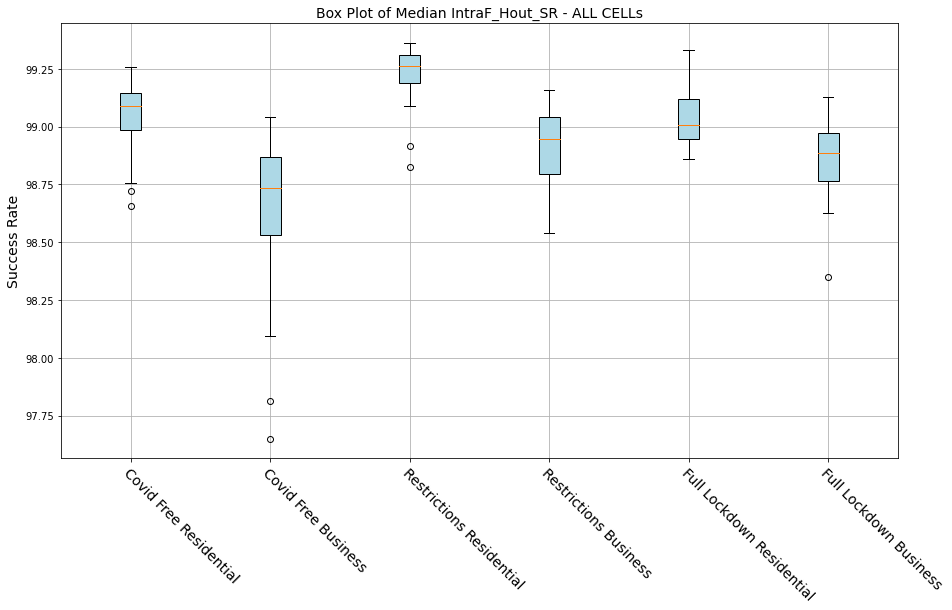


--------- Covid Free Residential IntraF_Hout_SR ---------
Median value: 99.09
Average value: 99.05
Standard deviation: 0.15
--------- Covid Free Business IntraF_Hout_SR ---------
Median value: 98.73
Average value: 98.67
Standard deviation: 0.29
--------- Restrictions Residential IntraF_Hout_SR ---------
Median value: 99.26
Average value: 99.22
Standard deviation: 0.13
--------- Restrictions Business IntraF_Hout_SR ---------
Median value: 98.95
Average value: 98.89
Standard deviation: 0.19
--------- Full Lockdown Residential IntraF_Hout_SR ---------
Median value: 99.01
Average value: 99.04
Standard deviation: 0.12
--------- Full Lockdown Business IntraF_Hout_SR ---------
Median value: 98.89
Average value: 98.87
Standard deviation: 0.17
>>>------ Covid Free Residential IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.36%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.39%
Std. 

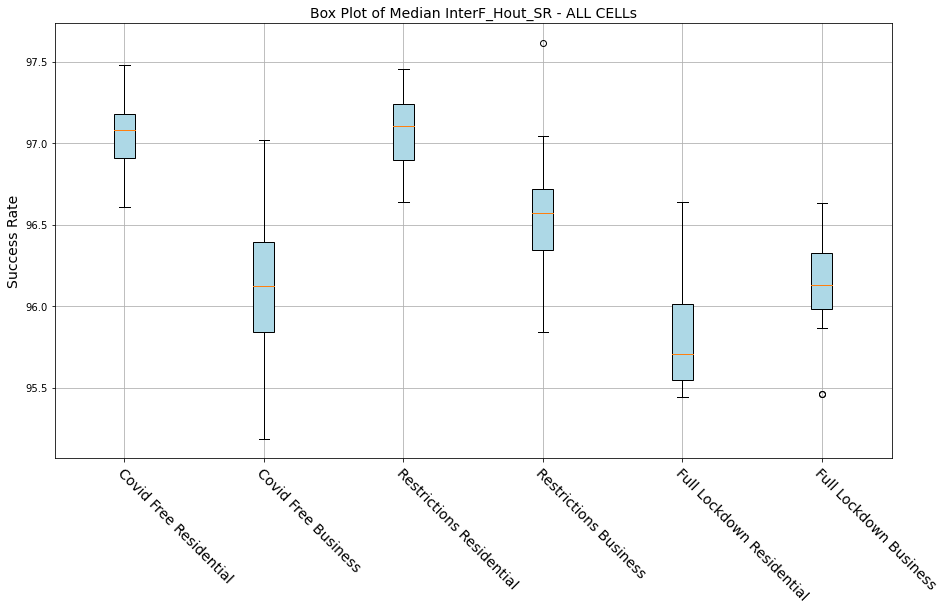


--------- Covid Free Residential InterF_Hout_SR ---------
Median value: 97.08
Average value: 97.06
Standard deviation: 0.20
--------- Covid Free Business InterF_Hout_SR ---------
Median value: 96.12
Average value: 96.09
Standard deviation: 0.42
--------- Restrictions Residential InterF_Hout_SR ---------
Median value: 97.11
Average value: 97.08
Standard deviation: 0.21
--------- Restrictions Business InterF_Hout_SR ---------
Median value: 96.57
Average value: 96.55
Standard deviation: 0.37
--------- Full Lockdown Residential InterF_Hout_SR ---------
Median value: 95.71
Average value: 95.86
Standard deviation: 0.37
--------- Full Lockdown Business InterF_Hout_SR ---------
Median value: 96.13
Average value: 96.11
Standard deviation: 0.28
>>>------ Covid Free Residential InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.98%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -1.00%
Std. 

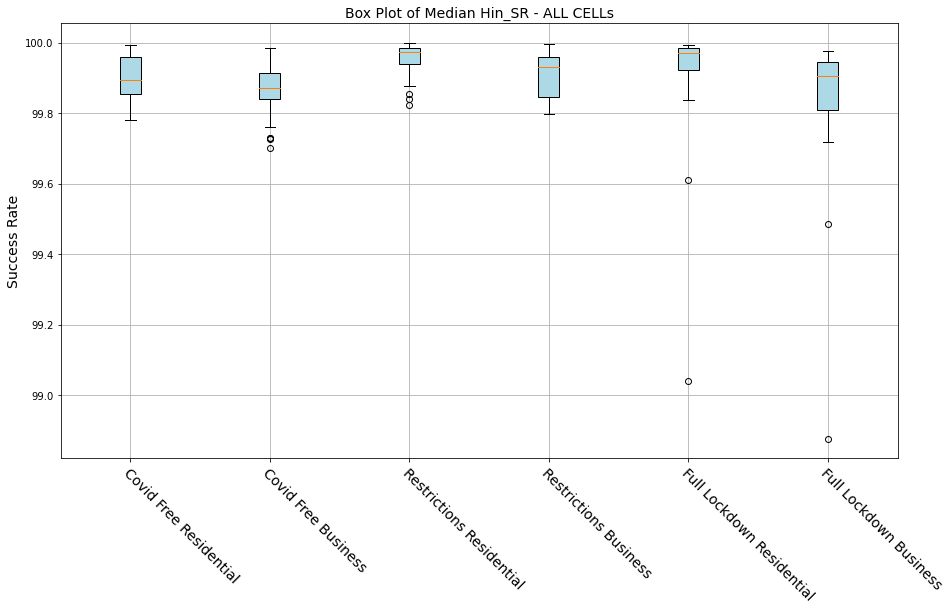


--------- Covid Free Residential Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Covid Free Business Hin_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.07
--------- Restrictions Residential Hin_SR ---------
Median value: 99.97
Average value: 99.95
Standard deviation: 0.05
--------- Restrictions Business Hin_SR ---------
Median value: 99.93
Average value: 99.91
Standard deviation: 0.06
--------- Full Lockdown Residential Hin_SR ---------
Median value: 99.97
Average value: 99.90
Standard deviation: 0.20
--------- Full Lockdown Business Hin_SR ---------
Median value: 99.90
Average value: 99.82
Standard deviation: 0.24
>>>------ Covid Free Residential Hin_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.02%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.03%
Std. deviation: difference between [ Covid Free Residential ]

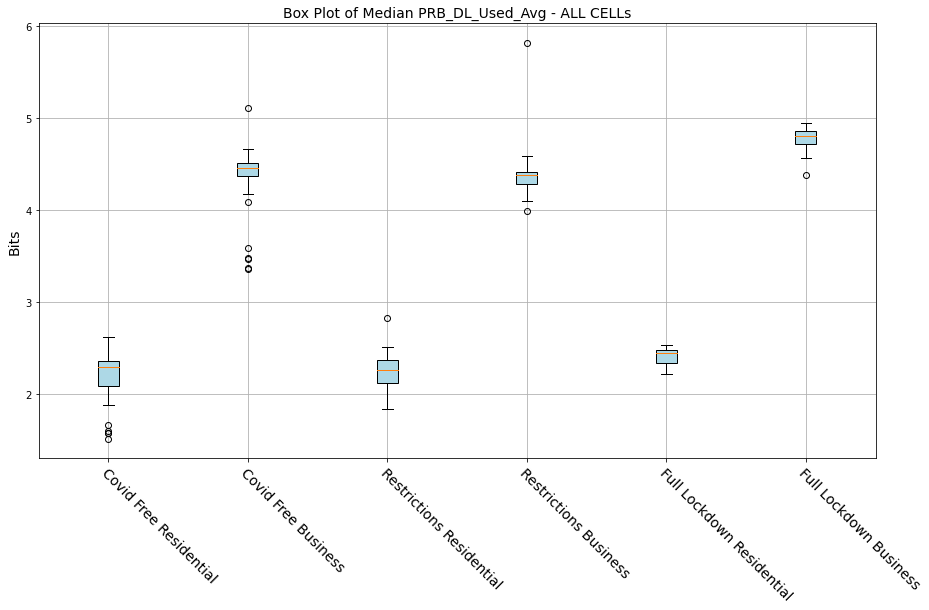


--------- Covid Free Residential PRB_DL_Used_Avg ---------
Median value: 2.29
Average value: 2.19
Standard deviation: 0.25
--------- Covid Free Business PRB_DL_Used_Avg ---------
Median value: 4.45
Average value: 4.35
Standard deviation: 0.34
--------- Restrictions Residential PRB_DL_Used_Avg ---------
Median value: 2.26
Average value: 2.25
Standard deviation: 0.22
--------- Restrictions Business PRB_DL_Used_Avg ---------
Median value: 4.38
Average value: 4.40
Standard deviation: 0.33
--------- Full Lockdown Residential PRB_DL_Used_Avg ---------
Median value: 2.45
Average value: 2.41
Standard deviation: 0.09
--------- Full Lockdown Business PRB_DL_Used_Avg ---------
Median value: 4.81
Average value: 4.77
Standard deviation: 0.13
>>>------ Covid Free Residential PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 94.33%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 98.98%
Std. devia

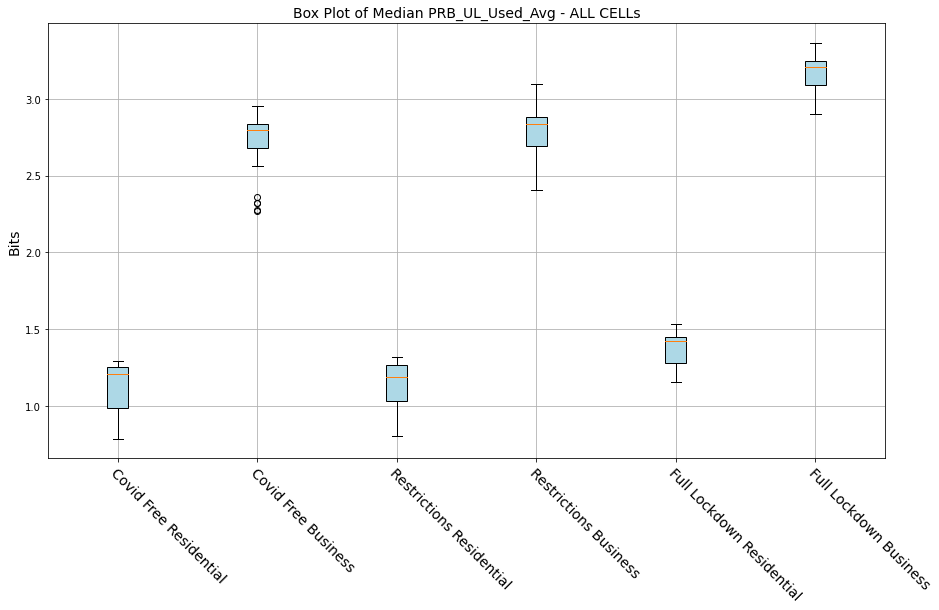


--------- Covid Free Residential PRB_UL_Used_Avg ---------
Median value: 1.20
Average value: 1.12
Standard deviation: 0.16
--------- Covid Free Business PRB_UL_Used_Avg ---------
Median value: 2.79
Average value: 2.74
Standard deviation: 0.17
--------- Restrictions Residential PRB_UL_Used_Avg ---------
Median value: 1.19
Average value: 1.13
Standard deviation: 0.16
--------- Restrictions Business PRB_UL_Used_Avg ---------
Median value: 2.84
Average value: 2.78
Standard deviation: 0.18
--------- Full Lockdown Residential PRB_UL_Used_Avg ---------
Median value: 1.42
Average value: 1.38
Standard deviation: 0.11
--------- Full Lockdown Business PRB_UL_Used_Avg ---------
Median value: 3.20
Average value: 3.18
Standard deviation: 0.12
>>>------ Covid Free Residential PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 131.94%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 144.77%
Std. dev

In [30]:
periods = [covid_free_residential, covid_free_business, restrictions_residential, restrictions_business, full_lockdown_residential, full_lockdown_business]
periods_lables = ['Covid Free Residential', 'Covid Free Business', 'Restrictions Residential', 'Restrictions Business', 'Full Lockdown Residential', 'Full Lockdown Business']
plot_stats(periods, periods_lables)